In [1]:
import seaborn as sns
sns.set_style("whitegrid")

from chase.process_model import *
from chase.fit_process import *
from chase.cpt import w_prelec, w_prime

from scipy.stats import norm
from scipy.stats.mstats import mquantiles

def expected_value(options):
    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    return np.sum(v, 1)


def evar(options):

    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    # expected variance of each option
    evar = np.array([np.dot(weights[i], values[i] ** 2) - np.sum(v[i]) ** 2 for i in range(len(options))])

    return evar

def max_ev(options):
    ev = expected_value(options)
    if ev[0] > ev[1]:
        return [1, 0]
    else:
        return [0, 1]


def max_var(options):
    v = evar(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def cv(options):
    ev = expected_value(options)
    sd = np.sqrt(evar(options))    
    return sd / ev


def max_cv(options):
    v = cv(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
cp = {}
bf_cp = {}

quant = {}
bf_quant = {}

N_ITER = 1

problems_str = {0: '4 w/ .8\nvs. 3',
                1: '-3 vs.\n-32 w/ .1',
                2: '-3 vs.\n-4 w/ .8',
                3: '32 w/ .1\nvs. 3',
                4: '32 w/ .025\nvs. 3 w/ .25',
                5: '3 vs.\n5 w/ .55',
                6: '4 w/ .9\nvs. 11 w/ .35',
                7: '-32 w/ .1\nvs. -12 w/ .25',
                8: '-3 w/ .35\nvs. -4 w/ .25'}

# load problems
probdf = pd.read_csv('data/frey2014/Frey14_ProblemTable_152.0.txt', sep=' ').reset_index()
Hind = {}
problems = {}

for i, row in probdf.iterrows():

    A = row[['outA1', 'probA1', 'outA2', 'probA2']].values.reshape(2,2)
    B = row[['outB1', 'probB1', 'outB2', 'probB2']].values.reshape(2,2)
    
    ev_A, ev_B = expected_value(np.array([A, B]))
    if ev_A > ev_B:
        Hind[i] = 0
        problems[i] = np.array([B, A], dtype=float)
    else:
        Hind[i] = 1
        problems[i] = np.array([A, B], dtype=float)

# Compile data

In [9]:
arr = []
for i, grp in enumerate(['happy', 'sad', 'fearful', 'angry']):
    dat = pd.read_csv('data/frey2014/Frey14_choice_152.%i.txt' % i, sep=' ')
    dat['group'] = grp
    dat.drop('order', axis=1, inplace=True)
    
    sampdat = pd.read_csv('data/frey2014/Frey14_sampling_152.%i.txt' % i, sep=' ')
    sampdat['group'] = grp
    arr.append(sampdat)

df = pd.concat(arr)

In [10]:
df.groupby(['subject']).apply(lambda d: np.sum(d.option==1)/float(d.shape[0])).values.mean()

0.49646370193780309

In [182]:
arr = []
for i, grp in enumerate(['happy', 'sad', 'fearful', 'angry']):
    dat = pd.read_csv('data/frey2014/Frey14_choice_152.%i.txt' % i, sep=' ')
    dat['group'] = grp
    dat.drop('order', axis=1, inplace=True)
    
    sampdat = pd.read_csv('paper/data/frey2014/Frey14_sampling_152.%i.txt' % i, sep=' ')
    sampdat = sampdat.groupby(['subject', 'problem']).apply(lambda d: d.shape[0]).reset_index()
    sampdat.columns = ['subject', 'problem', 'samplesize']
    
    arr.append(pd.merge(dat, sampdat, on=['subject', 'problem']))
    
data = pd.concat(arr).reset_index()
data['problem'] = data['problem'] - 1
data.drop('index', axis=1, inplace=True)

# recode choices as L/H
arr = []
for i, row in data.iterrows():
    probid = row['problem']
    arr.append(1*(row['choice'] == Hind[probid]))
data['choice'] = np.array(arr)

#data.to_csv('data/frey2014/frey2014_data.csv')

# Load data

In [2]:
data = pd.read_csv('data/frey2014/frey2014_data.csv', index_col=0)

In [3]:
data.samplesize.min(), data.samplesize.max()

(2, 369)

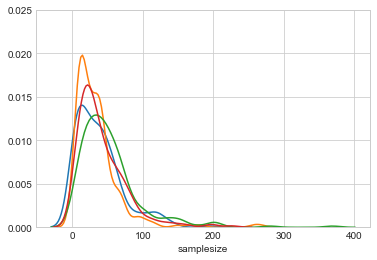

In [18]:
sns.distplot(data[data.group=='angry']['samplesize'], kde=True, hist=False)
sns.distplot(data[data.group=='happy']['samplesize'], kde=True, hist=False)
sns.distplot(data[data.group=='fearful']['samplesize'], kde=True, hist=False)
sns.distplot(data[data.group=='sad']['samplesize'], kde=True, hist=False)
plt.ylim(0, 0.025)
plt.show()

# Fit FHR14 (happy and fearful groups)

In [19]:
data = data[(data.group=='happy') | (data.group=='fearful')]

In [154]:
SIM_ID = 'process_FHR14'
OUTDIR = 'process_fitresults_FHR14'

FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}


PARSETS = [['tau', 'theta(group=happy)', 'theta(group=fearful)'],
           ['tau', 'pow_gain', 'theta(group=happy)', 'theta(group=fearful)'],
           ['tau', 'pow_gain',
            'prelec_elevation', 'prelec_gamma',
            'theta(group=happy)', 'theta(group=fearful)'],
           ['tau', 'pow_gain',
            'prelec_elevation(group=happy)', 'prelec_gamma(group=happy)',
            'prelec_elevation(group=fearful)', 'prelec_gamma(group=fearful)',
            'theta(group=happy)', 'theta(group=fearful)']
]

PARSETS = [['tau_trunc', 'theta(group=happy)', 'theta(group=fearful)'],
           ['tau_trunc', 'pow_gain', 'theta(group=happy)', 'theta(group=fearful)'],
           ['tau_trunc', 'pow_gain',
            'prelec_elevation', 'prelec_gamma',
            'theta(group=happy)', 'theta(group=fearful)'],
           ['tau_trunc', 'pow_gain',
            'prelec_elevation(group=happy)', 'prelec_gamma(group=happy)',
            'prelec_elevation(group=fearful)', 'prelec_gamma(group=fearful)',
            'theta(group=happy)', 'theta(group=fearful)']
]



m = CHASEProcessModel(problems=problems,
                      startdist='laplace')

In [ ]:
for fitting in PARSETS:
        
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

In [155]:
for fitting in PARSETS:
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    print best

index                                                                   0
Unnamed: 0                                                              0
iteration                                                               0
success                                                              True
nllh                                                              2883.72
k                                                                       3
N                                                                     504
bic                                                               5786.11
tau                                                               9.96725
theta(group=fearful)                                              35.5306
theta(group=happy)                                                28.7019
sim_id                  process_FHR14(tau,theta(group=fearful),theta(g...
Name: 0, dtype: object
index                                                                   0
Unnamed: 0     

In [126]:
fitting = PARSETS[0]
best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, data, SIM_ID, FIXED, 
                           fitting = fitting, groups=['group=happy', 'group=fearful'],
                           outdir=OUTDIR)
print best

index                                                                              0
Unnamed: 0                                                                         0
iteration                                                                          0
success                                                                         True
nllh                                                                         2798.65
k                                                                                  8
N                                                                                504
bic                                                                          5647.08
pow_gain                                                                    0.320118
prelec_elevation(group=fearful)                                             0.358853
prelec_elevation(group=happy)                                               0.534799
prelec_gamma(group=fearful)                                      

In [11]:
from cpt import pweight_prelec

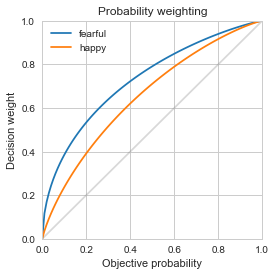

In [127]:
from mypy.viz import tableau20
from chase.cpt import w_prelec
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)


delta = .36
gamma = 1.17
axi.plot(p, w_prelec(p, delta, gamma), '-', color=tableau20[0], label='fearful')

#delta = .96
#gamma = .86
delta = .53
gamma = 1.2
axi.plot(p, w_prelec(p, delta, gamma), '-', color=tableau20[2], label='happy')


axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
axi.legend()
axi.set_xlim(0,1)
axi.set_ylim(0,1)
plt.tight_layout()
plt.show()

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in divide
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide


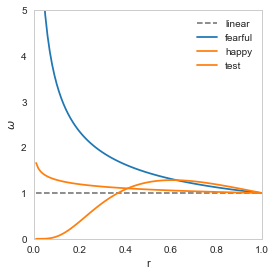

In [30]:
from mypy.viz import tableau20
from chase.cpt import w_prelec
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))

delta = 1
gamma = 1
axi.plot(p, w_prelec(p, delta, gamma)/p, '--', color='gray', label='linear')


delta = .47
gamma = 1
axi.plot(p, w_prelec(p, delta, gamma)/p, '-', color=tableau20[0], label='fearful')

#delta = .96
#gamma = .86
delta = .89
gamma = 1
axi.plot(p, w_prelec(p, delta, gamma)/p, '-', color=tableau20[2], label='happy')


delta = 1
gamma = 2
axi.plot(p, w_prelec(p, delta, gamma)/p, '-', color=tableau20[2], label='test')



axi.set_ylabel(r'$\omega$')
axi.set_xlabel('r')
axi.legend()
axi.set_xlim(0,1)
axi.set_ylim(0,5)
axi.grid(None)
plt.tight_layout()
plt.show()

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


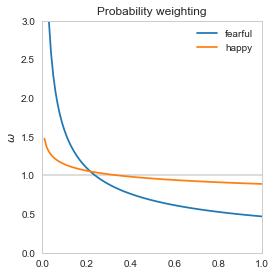

In [299]:
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))
axi.plot([0, 1], [1, 1], color='gray', alpha=.3)

delta = .47
gamma = 1
axi.plot(p, w(p, delta, gamma), '-', color=tableau20[0], label='fearful')

#delta = .96
#gamma = .86
delta = .89
gamma = 1
axi.plot(p, w(p, delta, gamma), '-', color=tableau20[2], label='happy')


axi.set_title('Probability weighting')
#axi.set_xlabel('Objective probability')
axi.set_ylabel(r'$\omega$')
axi.legend()
axi.set_xlim(0,1)
axi.set_ylim(0,3)

axi.grid(None)
plt.tight_layout()
plt.show()

In [129]:
data['bf_cp'] = pred['cp'].values
data['ss(.25)'] = pred['ss(.25)'].values
data['ss(.5)'] = pred['ss(.5)'].values
data['ss(.75)'] = pred['ss(.75)'].values

In [130]:
for group in ['happy', 'fearful']:
    cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.choice))
    bf_cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.bf_cp))

    quant[group] = mquantiles(data[data.group==group].samplesize)
    bf_quant[group] = data[data.group==group][['ss(.25)', 'ss(.5)', 'ss(.75)']].mean()

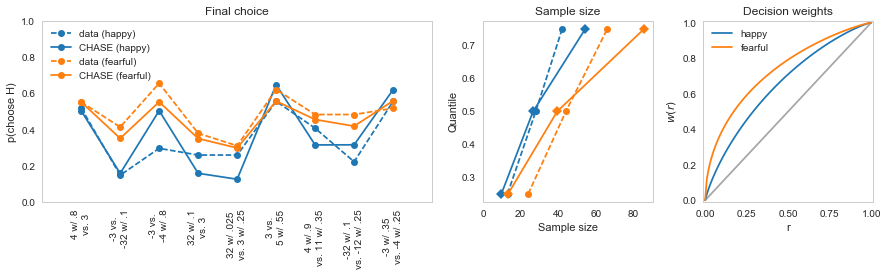

In [181]:
from mypy.viz import tableau20

n_prob = len(problems)

cols = [tableau20[0], tableau20[2]]

fig = plt.subplots(2, 2, figsize=(12.5, 4))

# choice probs
axi = plt.subplot2grid((1,4), (0,0), colspan=2)
#axi.text(-.25, 1.05, 'A', fontsize=18, fontweight='semibold', transform=axi.transAxes)
axi.plot(range(1, n_prob+1), data[data.group=='happy'].groupby('problem').apply(lambda d: np.mean(d.choice)), '--o',
         color=cols[0], label='data (happy)')
axi.plot(range(1, n_prob+1), bf_cp['happy'], '-o', color=cols[0], label='CHASE (happy)')
axi.plot(range(1, n_prob+1), data[data.group=='fearful'].groupby('problem').apply(lambda d: np.mean(d.choice)), '--o',
         color=cols[1], label='data (fearful)')
axi.plot(range(1, n_prob+1), bf_cp['fearful'], '-o', color=cols[1], label='CHASE (fearful)')
axi.set_ylim(0, 1)
axi.set_xlim(0, n_prob+1)
axi.set_xticks(range(1,n_prob+1))
axi.set_xticklabels([problems_str[i] for i in range(9)], rotation=90)
#axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.grid(None)
axi.set_title('Final choice')
axi.legend(loc='upper left')

# sample size
axi = plt.subplot2grid((1,4), (0,2))
axi.plot(quant['happy'], [.25, .5, .75], '--o', color=cols[0], label='data (happy)')
axi.plot(bf_quant['happy'], [.25, .5, .75], '-D', color=cols[0], label='CHASE (happy)')

axi.plot(quant['fearful'], [.25, .5, .75], '--o', color=cols[1], label='data (fearful)')
axi.plot(bf_quant['fearful'], [.25, .5, .75], '-D', color=cols[1], label='CHASE (fearful)')


axi.set_title('Sample size')
axi.set_xlim(0, 90)
#axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

#axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axi.grid(None)




p = np.arange(0, 1.01, .01)


axi = plt.subplot2grid((1,4), (0,3))
axi.plot([0, 1], [0, 1], color='gray', alpha=.7)


delta = best['prelec_elevation(group=happy)']
gamma = best['prelec_gamma(group=happy)']
axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[0], label='happy')

delta = best['prelec_elevation(group=fearful)']
gamma = best['prelec_gamma(group=fearful)']
axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[1], label='fearful')

axi.set_title('Decision weights')
axi.set_ylabel(r'$w(r)$')
axi.set_xlabel('r')
axi.legend()
axi.set_xlim(-.01,1.01)
axi.set_ylim(-.01,1.01)
axi.grid(None)

#y = -.26
#axi.plot([0, 1], [y, y], '-', clip_on=False, color='gray')
#axi.plot([.025, .1, .25, .8, 1], [y, y, y, y, y], 'D', clip_on=False, markeredgecolor='black',
#         markerfacecolor='None', markeredgewidth=1)




#axi.plot([0, 1], [1, 1], color='gray', alpha=.7)


#delta = best['prelec_elevation(group=happy)']
#gamma = best['prelec_gamma(group=happy)']
#axi.plot(p, w(p, delta, gamma), '-', color=cols[0], label='happy')

#delta = best['prelec_elevation(group=fearful)']
#gamma = best['prelec_gamma(group=fearful)']
#axi.plot(p, w(p, delta, gamma), '-', color=cols[1], label='fearful')


#axi.set_title('Attentional weights')
#axi.set_ylabel(r'$\omega$')
#axi.set_xlabel('r')
#axi.legend()
#axi.set_xlim(-.01,1.01)
#axi.set_ylim(-.01,3)
#axi.grid(None)



#y = -.75
#axi.plot([0, 1], [y, y], '-', clip_on=False, color='gray')
#axi.plot([.025, .1, .25, .8, 1], [y, y, y, y, y], 'D', clip_on=False, markeredgecolor='black',
#         markerfacecolor='None', markeredgewidth=1)


#axi.text(-.25, 1.05, 'B', fontsize=18, fontweight='semibold', transform=axi.transAxes)


plt.tight_layout()
plt.show()
fig[0].savefig('%s/fitresults_frey2014.pdf' % FIGDEST, bbox_inches='tight')

# Fit conditions indvidually

In [4]:
OUTDIR = 'process_fitresults_FHR14'
FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000}

PARSETS = {}
PARSETS['optional'] = [#['theta', 'tau_trunc', 'c_sigma'],
                       #['theta', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                       ['theta', 'tau_trunc', 'c_sigma', 'pow_gain', 'prelec_elevation', 'prelec_gamma'],
                       ]

PARSETS['geometric'] = [['p_stop_geom', 'tau', 'c_sigma'],
                        ['p_stop_geom', 'tau', 'c_sigma', 'prelec_elevation', 'prelec_gamma'],
                        ['p_stop_geom', 'tau', 'c_sigma', 'pow_gain', 'prelec_elevation', 'prelec_gamma'],
                        ]

In [ ]:
#for stoprule in ['optional', 'geometric']:
for stoprule in ['optional']:
    

    FIXED = {'minsamplesize': 2, 
             'max_T': 1000, 
             'N': 20000, 
             'stoprule': stoprule}

    #for group in ['happy', 'sad', 'fearful', 'angry']:
    for group in ['happy', 'fearful']:

        if stoprule == 'optional':
            SIM_ID = 'process_FHR14_%s' % group
            OUTDIR = 'process_fitresults_FHR14_%s' % group
            m = CHASEProcessModel(problems=problems,
                                  stoprule='optional')

        elif stoprule == 'geometric':
            SIM_ID = 'process_planned_FHR14_%s' % group
            OUTDIR = 'process_planned_fitresults_FHR14_%s' % group
            m = CHASEProcessModel(problems=problems,
                                  stoprule='fixedGeom')

        grpdata = data[data.group==group]
        print SIM_ID

        for fitting in PARSETS[stoprule]:

            results = fit_mlh(m, problems, grpdata, 
                              SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

process_FHR14_happy
c_sigma	pow_gain	prelec_elevation	prelec_gamma	tau_trunc	theta


/Users/dmarkant/projects/chase/chase/cpt.py:40: RuntimeWarning: divide by zero encountered in log
  f = np.exp(-delta * ((-np.log(p)) ** gamma))
/Users/dmarkant/projects/chase/chase/process_model.py:107: RuntimeWarning: invalid value encountered in divide
  omega.append(weights[i]/option[:,1])


[ 54.79   0.44   2.85   1.01  82.44  78.08] --> 2097.2	[time: 7.62]
[ 15.46   0.76   1.16   0.82  90.69  87.22] --> 1262.5	[time: 7.17]
[ 92.58   1.32   0.95   0.41  99.95  40.79] --> 2625.8	[time: 6.87]
[  11.48    0.41    0.37    0.27   17.92  113.02] --> 1468.8	[time: 7.14]
[  77.87    0.15    2.13    2.49   28.22  105.22] --> 2126.9	[time: 7.32]
[  14.17    1.23    1.19    1.52   55.72  124.14] --> 1307.6	[time: 7.43]
[ 20.49   0.83   1.46   2.72  69.07  71.7 ] --> 1382.1	[time: 7.17]
[  22.71    0.22    2.68    1.05    8.74  126.86] --> 1251.5	[time: 7.31]
[  3.19300000e+01   4.00000000e-02   6.90000000e-01   2.06000000e+00
   4.43000000e+01   6.85300000e+01] --> 1748.8	[time: 7.28]
[ 61.21   1.42   0.65   0.74   2.05  64.16] --> 2320.4	[time: 7.27]
[  40.15    1.05    0.18    2.57   46.5   110.81] --> 1580.8	[time: 6.83]
[  83.23    1.29    1.84    2.32   20.32  134.43] --> 2003.9	[time: 6.8]
[  50.46    0.37    1.33    0.18   23.28  115.94] --> 1664.8	[time: 6.78]
[   9.64    0.

[ 31.96   1.06   2.84   2.64   6.48  94.81] --> 1444.0	[time: 6.72]
[ 30.01   0.96   1.43   2.86  37.59  91.96] --> 1442.3	[time: 7.18]
[ 36.04   0.11   2.78   2.39   3.97  51.86] --> 2089.3	[time: 7.28]
[  6.17   0.68   2.58   2.12  31.5   46.62] --> 1325.3	[time: 7.19]
[ 43.61   0.34   2.45   2.6   21.3   91.07] --> 1759.5	[time: 7.33]
[ 26.38   0.54   2.15   2.64  10.58  98.76] --> 1312.9	[time: 7.31]
[ 15.36   0.19   2.18   1.74  49.46  97.6 ] --> 1258.0	[time: 7.43]
[  9.54000000e+01   7.00000000e-02   2.42000000e+00   1.44000000e+00
   4.11300000e+01   1.32770000e+02] --> 2114.7	[time: 7.4]
[   2.66    0.76    0.21    2.3    35.88  130.25] --> 2071.6	[time: 7.45]
[ 33.73   0.4    2.85   1.74  35.02  55.23] --> 1989.0	[time: 7.29]
[  31.99    1.4     2.92    1.91   84.58  147.36] --> 1287.8	[time: 7.53]
[  24.      1.36    2.76    1.99   53.3   119.16] --> 1280.0	[time: 7.79]
[  46.8     0.23    1.98    2.18   38.57  101.57] --> 1723.3	[time: 7.69]
[  30.11    0.18    2.27    2.69

[  77.7     0.12    2.65    0.9    40.53  109.85] --> 2119.6	[time: 7.5]
[  3.28400000e+01   5.00000000e-02   9.40000000e-01   1.12000000e+00
   3.23000000e+01   1.01990000e+02] --> 1423.8	[time: 7.43]
[ 79.42   0.7    1.39   1.46  18.08  71.88] --> 2356.7	[time: 7.27]
[  36.36    0.47    0.63    1.89   40.06  147.66] --> 1288.5	[time: 7.44]
[  15.16    0.29    1.43    2.47    9.    115.32] --> 1334.6	[time: 7.49]
[  7.91000000e+00   1.00000000e-01   8.60000000e-01   1.32000000e+00
   1.54000000e+00   1.48570000e+02] --> 2273.3	[time: 7.48]
[  28.84    0.22    1.93    2.75   25.7   124.04] --> 1278.0	[time: 7.9]
[  1.84000000e+00   8.00000000e-02   2.34000000e+00   1.52000000e+00
   2.02800000e+01   9.71800000e+01] --> 2241.0	[time: 8.89]
[  49.16    0.94    0.68    1.05   11.78  107.85] --> 1728.5	[time: 8.99]
[ 23.32   0.34   0.55   1.81  50.58  45.13] --> 1845.4	[time: 8.48]
[ 14.62   0.99   1.58   1.53  36.68  84.22] --> 1254.9	[time: 8.0]
[ 19.85   0.57   0.57   0.06  31.35   7.46

[  22.19    0.92    0.27    2.23    5.96  112.91] --> 1278.6	[time: 7.34]
[  39.2     1.07    1.85    0.23   63.46  126.96] --> 1437.2	[time: 7.36]
[  19.77    0.83    1.02    1.89   56.44  115.39] --> 1253.7	[time: 7.33]
[   7.43    0.33    2.86    2.53   34.34  130.28] --> 1638.5	[time: 7.33]
[   2.59    0.68    2.95    2.87   50.92  131.37] --> 1946.5	[time: 7.44]
[ 14.67   0.76   1.53   1.14  24.09  49.17] --> 1399.8	[time: 7.2]
[  24.16    1.16    0.83    1.48   14.48  115.92] --> 1260.1	[time: 7.32]
[ 18.89   0.72   1.07   2.96   9.29  64.94] --> 1356.1	[time: 7.24]
[ 22.05   0.19   1.05   0.57  97.09  91.89] --> 1313.6	[time: 7.3]
[ 18.2    0.47   0.79   0.82  23.67  41.78] --> 1689.8	[time: 7.16]
[ 22.07   0.41   2.43   0.43   2.76  80.67] --> 1313.1	[time: 7.14]
[   3.07    0.94    0.95    1.89   55.02  117.63] --> 1775.8	[time: 7.4]
[  1.12700000e+01   3.00000000e-02   9.50000000e-01   1.38000000e+00
   2.87000000e+00   1.04990000e+02] --> 1490.1	[time: 7.37]
[  67.94    0.24

[   9.32    0.45    1.42    2.08   86.17  121.45] --> 1407.0	[time: 7.87]
[  26.53    0.46    0.64    2.45   20.28  149.05] --> 1246.7	[time: 8.26]
[ 16.51   0.53   1.92   2.99   3.75  79.28] --> 1249.2	[time: 7.22]
[  1.76   0.56   2.25   1.75  52.64  53.09] --> 1666.6	[time: 7.73]
[ 42.58   0.79   1.11   0.77  39.    40.64] --> 2333.4	[time: 8.45]
[ 17.34   0.7    2.6    1.14  49.94  52.32] --> 1472.6	[time: 7.9]
[  3.99   0.46   0.78   2.59  51.64  56.11] --> 1419.3	[time: 7.17]
[ 28.84   0.37   0.71   2.09  30.18  88.79] --> 1432.9	[time: 7.25]
[  8.44   0.47   1.03   1.91  38.68  77.23] --> 1308.0	[time: 7.52]
[  16.23    0.33    1.6     2.59   54.43  103.09] --> 1254.4	[time: 9.07]
[  2.51300000e+01   9.00000000e-02   3.20000000e-01   1.26000000e+00
   9.96800000e+01   2.77300000e+01] --> 2257.7	[time: 7.87]
[  7.64   0.29   0.15   1.73  94.1   86.08] --> 1372.8	[time: 7.89]
[  6.78000000e+00   4.60000000e-01   1.47000000e+00   3.00000000e-02
   8.05700000e+01   9.33300000e+01] -

[  22.45    0.41    0.54    1.32   64.67  113.03] --> 1265.1	[time: 7.07]
[  16.28    1.27    1.14    1.92   36.98  100.69] --> 1273.6	[time: 7.17]
[ 16.38   0.65   1.2    2.05  60.19  74.21] --> 1283.2	[time: 7.31]
[ 34.29   0.29   0.79   1.45  47.3   94.12] --> 1522.3	[time: 7.34]
[  13.61    1.22    1.68    3.     76.72  118.67] --> 1335.4	[time: 7.71]
[  24.53    0.26    1.18    1.76   36.59  138.58] --> 1242.8	[time: 7.76]
[ 10.05   1.3    0.71   2.56  18.19  72.04] --> 1434.0	[time: 7.25]
[ 21.43   0.31   0.97   1.93  15.41  68.09] --> 1407.3	[time: 7.89]
[  25.23    0.22    0.54    2.52   27.07  133.21] --> 1240.7	[time: 11.27]
[ 20.15   0.31   1.3    2.7   17.34  78.93] --> 1304.9	[time: 7.62]
[  2.16300000e+01   3.00000000e-02   2.36000000e+00   9.50000000e-01
   4.76000000e+01   7.12600000e+01] --> 1413.1	[time: 7.57]
[  10.3     0.18    1.21    0.8    18.41  123.6 ] --> 1539.5	[time: 7.45]
[  30.15    0.19    0.74    2.63   37.27  112.83] --> 1331.0	[time: 7.33]
[ 26.27   0.

[ 19.15   0.53   2.63   2.35  45.53  82.82] --> 1290.3	[time: 8.01]
[ 12.07   0.53   2.36   2.36  51.94  96.27] --> 1288.0	[time: 7.78]
[  30.71    0.37    1.89    1.18   15.85  132.8 ] --> 1263.5	[time: 7.8]
[  23.7     0.27    2.67    2.59   27.2   117.39] --> 1247.6	[time: 8.51]
[ 20.12   0.83   0.76   1.08   1.66  65.6 ] --> 1393.0	[time: 7.62]
[ 52.29   0.15   2.68   1.25  27.49   7.39] --> 2719.3	[time: 6.96]
[  2.41500000e+01   1.00000000e-02   1.56000000e+00   1.13000000e+00
   1.23400000e+01   1.46690000e+02] --> 1261.2	[time: 7.68]
[  2.11000000e+01   3.80000000e-01   1.00000000e-02   1.44000000e+00
   6.59600000e+01   6.81100000e+01] --> 1472.6	[time: 8.56]
[  25.29    0.23    0.92    2.01   17.41  125.1 ] --> 1248.1	[time: 8.96]
[ 10.85   0.24   2.64   2.13   1.79  55.43] --> 1247.6	[time: 8.1]
[ 19.57   0.46   2.98   1.8   18.14  84.15] --> 1272.6	[time: 7.63]
[  15.8     0.39    1.5     1.61   25.69  133.22] --> 1325.1	[time: 7.82]
[ 22.25   0.26   1.19   2.38   4.5   97.

[ 16.51   0.43   0.42   2.13  23.41  74.83] --> 1261.5	[time: 7.79]
[ 11.25   0.25   0.78   0.81  25.25  61.41] --> 1247.9	[time: 7.87]
[ 18.94   0.35   0.93   1.26  56.76  77.  ] --> 1311.9	[time: 7.82]
[ 14.83   0.58   2.43   1.57  61.89  68.88] --> 1286.2	[time: 7.43]
[ 14.98   0.4    0.81   1.91  86.35  49.78] --> 1414.0	[time: 7.22]
[ 20.24   0.68   2.58   1.33   6.77  46.62] --> 1651.4	[time: 7.31]
[ 16.28   0.71   0.89   1.37  16.97  71.19] --> 1267.7	[time: 7.2]
[ 19.27   0.24   1.81   1.84   4.05  71.47] --> 1311.3	[time: 7.18]
[ 15.15   0.19   1.32   1.41  45.96  97.6 ] --> 1252.7	[time: 7.31]
[   5.74    0.27    0.47    2.57    4.25  128.51] --> 2382.1	[time: 7.42]
[ 13.94   0.4    0.56   1.03  18.02  71.32] --> 1249.4	[time: 7.25]
[  8.11   0.34   1.26   1.6    9.49  59.39] --> 1289.3	[time: 7.14]
[ 11.95   0.24   0.64   0.62   4.5   69.03] --> 1251.6	[time: 7.18]
[ 12.43   0.28   1.87   1.25  11.82  64.83] --> 1242.5	[time: 7.44]
[  17.64    0.17    0.66    2.59    6.94  1

[  2.73700000e+01   1.90000000e-01   1.00000000e-01   1.43000000e+00
   1.73600000e+01   1.29320000e+02] --> 1261.4	[time: 8.15]
[ 12.45   0.52   1.1    1.97  34.58  69.04] --> 1251.9	[time: 7.63]
[ 15.46   0.35   2.53   2.12  14.55  51.47] --> 1392.8	[time: 7.65]
[ 15.88   0.2    0.75   1.06  32.25  82.59] --> 1252.0	[time: 7.89]
[  9.41   0.38   2.84   2.59  32.41  59.02] --> 1263.0	[time: 8.11]
[ 14.41   0.17   0.36   1.65  94.68  70.01] --> 1281.0	[time: 8.03]
[  11.39    0.25    1.09    2.57   22.9   116.21] --> 1405.8	[time: 8.09]
[ 29.3    0.76   0.72   1.69  16.79  67.63] --> 1662.8	[time: 7.83]
[  17.96    0.44    0.2     2.6    67.91  105.43] --> 1261.0	[time: 7.72]
[  10.23    1.23    1.83    0.54    0.36  115.8 ] --> 1695.8	[time: 7.7]
[  22.45    1.07    1.21    1.61   19.23  117.46] --> 1241.9	[time: 7.71]
[ 13.39   0.24   0.68   1.05  16.41  84.18] --> 1252.6	[time: 7.93]
[  26.01    1.26    2.21    0.73   56.44  128.57] --> 1261.1	[time: 7.94]
[  2.52500000e+01   1.0000

[  2.36100000e+01   1.20000000e-01   1.92000000e+00   1.16000000e+00
   9.52000000e+00   1.25590000e+02] --> 1248.2	[time: 7.29]
[ 25.37   0.12   0.91   0.33  13.44  29.4 ] --> 2239.8	[time: 7.05]
[  17.7     0.14    2.      0.43   17.36  129.85] --> 1301.4	[time: 7.39]
[  1.59300000e+01   3.00000000e-02   5.10000000e-01   1.68000000e+00
   4.21000000e+00   8.39700000e+01] --> 1239.7	[time: 7.38]
[  1.61300000e+01   7.00000000e-02   6.70000000e-01   1.40000000e-01
   2.66500000e+01   9.16000000e+01] --> 1247.5	[time: 7.31]
[ 20.51   0.26   1.3    2.1   65.77  95.49] --> 1279.8	[time: 7.26]
[ 15.02   0.48   2.46   2.84  15.    82.23] --> 1244.5	[time: 7.23]
[  18.56    0.26    1.13    1.14   92.53  123.8 ] --> 1261.6	[time: 7.48]
[ 10.58   0.46   0.91   1.72   8.18  64.23] --> 1248.5	[time: 7.19]
[  3.20000000e+01   5.00000000e-02   4.60000000e-01   7.20000000e-01
   2.46100000e+01   1.10880000e+02] --> 1359.1	[time: 7.33]
[  9.69   0.27   2.07   2.05  13.3   41.08] --> 1283.5	[time: 7.

[  17.66    0.52    0.82    0.69   65.3   110.38] --> 1265.0	[time: 8.62]
[ 12.51   0.15   1.45   1.86  76.27  44.5 ] --> 1385.4	[time: 8.71]
[ 17.56   0.29   1.26   2.42  13.46  93.18] --> 1239.7	[time: 8.09]
[  8.46   0.31   2.28   1.29   3.93  49.41] --> 1261.1	[time: 7.64]
[ 11.28   0.52   1.61   2.89  60.19  74.21] --> 1267.7	[time: 8.16]
[ 16.93   0.21   2.59   0.97  87.33  94.39] --> 1262.2	[time: 8.08]
[  8.65600000e+01   9.00000000e-02   1.00000000e+00   1.00000000e+00
   1.78000000e+00   9.76600000e+01] --> 2246.6	[time: 8.09]
[  6.61   0.35   1.18   1.81  71.39  48.72] --> 1276.9	[time: 8.23]
[  1.37200000e+01   3.00000000e-02   1.86000000e+00   1.85000000e+00
   4.28900000e+01   7.99400000e+01] --> 1252.6	[time: 8.13]
[  15.67    0.35    0.76    1.88   11.36  134.19] --> 1393.8	[time: 7.96]
[  1.67100000e+01   2.20000000e-01   1.00000000e-02   2.52000000e+00
   2.83400000e+01   7.50800000e+01] --> 1298.3	[time: 8.31]
[ 13.27   1.12   2.24   1.85  18.52  93.07] --> 1304.8	[t

In [24]:
results = pd.DataFrame([], columns=['model', 'sim_id', 'dataset', 'stoprule', 'k', 'N', 'nllh', 'bic', 
                                    'tau', 'tau_trunc', 'tau_unif',
                                    'theta', 'p_stop_geom', 'sc', 'sc2', 'sc0', 'c', 'c_sigma', 'c_0', 
                                    'pow_gain', 'w_loss', 'prelec_elevation', 'prelec_gamma'])
    
for group in ['happy', 'sad', 'fearful', 'angry']:
    
    for stoprule in ['optional', 'geometric']:
    
        if stoprule == 'optional':
            SIM_ID = 'process_FHR14_%s' % group
            OUTDIR = 'process_fitresults_FHR14_%s' % group
        elif stoprule == 'geometric':
            SIM_ID = 'process_planned_FHR14_%s' % group
            OUTDIR = 'process_planned_fitresults_FHR14_%s' % group
        FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': stoprule}

        
        
        for i, parset in enumerate(PARSETS[stoprule]):
            b = best_result(SIM_ID, FIXED, parset, outdir=OUTDIR)
            if b is not None:
                b['model'] = i
                b['dataset'] = group
                b['stoprule'] = stoprule
                results.loc[results.shape[0]] = b
                
results['pars'] = results['sim_id'].apply(lambda d: d.split('|')[0].split('(', 1)[1])

In [25]:
results.sort_values(by=['dataset', 'bic'])

,model,sim_id,dataset,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_unif,theta,p_stop_geom,sc,sc2,sc0,c,c_sigma,c_0,pow_gain,w_loss,prelec_elevation,prelec_gamma,pars
13,1,"process_FHR14_angry(c_sigma,prelec_elevation,p...",angry,optional,5,252,1322.876914,2673.400973,NaN,98.143473,NaN,136.350456,NaN,NaN,NaN,NaN,NaN,22.324144,NaN,NaN,NaN,1.827758,0.919730,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
12,0,"process_FHR14_angry(c_sigma,tau_trunc,theta|N=...",angry,optional,3,252,1329.633905,2675.856098,NaN,95.881956,NaN,148.311014,NaN,NaN,NaN,NaN,NaN,22.960704,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau_trunc,theta"
14,0,"process_planned_FHR14_angry(c_sigma,p_stop_geo...",angry,geometric,3,252,1331.912681,2680.413650,169.633532,NaN,NaN,NaN,0.027573,NaN,NaN,NaN,NaN,73.158836,NaN,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom,tau"
15,1,"process_planned_FHR14_angry(c_sigma,p_stop_geo...",angry,geometric,5,252,1328.206657,2684.060459,45.606193,NaN,NaN,NaN,0.025269,NaN,NaN,NaN,NaN,29.178382,NaN,NaN,NaN,2.649867,0.870772,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."
8,0,"process_FHR14_fearful(c_sigma,tau_trunc,theta|...",fearful,optional,3,261,1459.687498,2936.068557,NaN,24.706546,NaN,149.665401,NaN,NaN,NaN,NaN,NaN,21.173980,NaN,NaN,NaN,NaN,NaN,"c_sigma,tau_trunc,theta"
9,1,"process_FHR14_fearful(c_sigma,prelec_elevation...",fearful,optional,5,261,1458.716753,2945.256108,NaN,28.848030,NaN,146.422355,NaN,NaN,NaN,NaN,NaN,20.436597,NaN,NaN,NaN,1.084684,1.069538,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
10,0,"process_planned_FHR14_fearful(c_sigma,p_stop_g...",fearful,geometric,3,261,1468.021468,2952.736497,140.129763,NaN,NaN,NaN,0.019596,NaN,NaN,NaN,NaN,39.197717,NaN,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom,tau"
11,1,"process_planned_FHR14_fearful(c_sigma,p_stop_g...",fearful,geometric,5,261,1467.061315,2961.945231,19.718255,NaN,NaN,NaN,0.021255,NaN,NaN,NaN,NaN,69.302525,NaN,NaN,NaN,1.972616,1.364455,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."
1,1,"process_FHR14_happy(c_sigma,prelec_elevation,p...",happy,optional,5,243,1237.447543,2502.360394,NaN,24.368830,NaN,128.714208,NaN,NaN,NaN,NaN,NaN,23.461028,NaN,NaN,NaN,1.370204,1.463470,"c_sigma,prelec_elevation,prelec_gamma,tau_trun..."
3,1,"process_planned_FHR14_happy(c_sigma,p_stop_geo...",happy,geometric,5,243,1245.504047,2518.473401,185.793229,NaN,NaN,NaN,0.028698,NaN,NaN,NaN,NaN,19.946907,NaN,NaN,NaN,1.234976,2.100982,"c_sigma,p_stop_geom,prelec_elevation,prelec_ga..."


In [26]:
tab = results[['dataset', 'stoprule', 'model', 'N', 'k', 'nllh', 'bic', 'p_stop_geom', 'theta', 'tau', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma']]
tab.to_csv('results_fits/FHR14_allmodels.csv')
tab

,dataset,stoprule,model,N,k,nllh,bic,p_stop_geom,theta,tau,tau_trunc,c_sigma,prelec_elevation,prelec_gamma
0,happy,optional,0,243,3,1254.484080,2525.447344,NaN,125.756560,NaN,14.981689,24.985480,NaN,NaN
1,happy,optional,1,243,5,1237.447543,2502.360394,NaN,128.714208,NaN,24.368830,23.461028,1.370204,1.463470
2,happy,geometric,0,243,3,1259.757005,2535.993195,0.032978,NaN,193.958585,NaN,28.618574,NaN,NaN
3,happy,geometric,1,243,5,1245.504047,2518.473401,0.028698,NaN,185.793229,NaN,19.946907,1.234976,2.100982
4,sad,optional,0,252,3,1355.381938,2727.352162,NaN,115.702008,NaN,29.229323,18.714768,NaN,NaN
5,sad,optional,1,252,5,1332.981409,2693.609963,NaN,130.316107,NaN,26.823869,19.817246,1.977634,0.878634
6,sad,geometric,0,252,3,1357.033400,2730.655088,0.023524,NaN,194.384097,NaN,44.573468,NaN,NaN
7,sad,geometric,1,252,5,1345.606712,2718.860570,0.026394,NaN,157.686220,NaN,29.507589,2.299460,1.107787
8,fearful,optional,0,261,3,1459.687498,2936.068557,NaN,149.665401,NaN,24.706546,21.173980,NaN,NaN
9,fearful,optional,1,261,5,1458.716753,2945.256108,NaN,146.422355,NaN,28.848030,20.436597,1.084684,1.069538


In [33]:
fitting = PARSETS['optional'][1]
FIXED = {'minsamplesize': 2, 'max_T': 1000, 'N': 20000, 'stoprule': 'optional'}
m = CHASEProcessModel(problems=problems,
                      stoprule='optional')

best = {}
pred = {}

for group in ['happy', 'sad', 'fearful', 'angry']:
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    OUTDIR = 'process_fitresults_FHR14_%s' % group
    
    best[group] = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred[group] = predict_from_result(m, problems, grpdata, SIM_ID, FIXED, 
                                      fitting = fitting, outdir=OUTDIR, N=20000)
    print best[group]

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1237.45
k                                                                   5
N                                                                 243
bic                                                           2502.36
c_sigma                                                        23.461
prelec_elevation                                               1.3702
prelec_gamma                                                  1.46347
tau_trunc                                                     24.3688
theta                                                         128.714
sim_id              process_FHR14_happy(c_sigma,prelec_elevation,p...
Name: 0, dtype: obje

In [34]:
cp = {}
bf_cp = {}
quant = {}
bf_quant = {}

for group in ['happy', 'sad', 'fearful', 'angry']:
    cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.choice))
    bf_cp[group] = pred[group].groupby('problem').apply(lambda d: np.mean(d.pred_cp))

    quant[group] = mquantiles(data[data.group==group].samplesize)
    bf_quant[group] = pred[group][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].mean()

In [36]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)


In [37]:
#from mypy.viz import tableau20
cols = [tableau20[0], tableau20[2], tableau20[4], tableau20[6]]
cols = ['black', 'black', 'black', 'black']

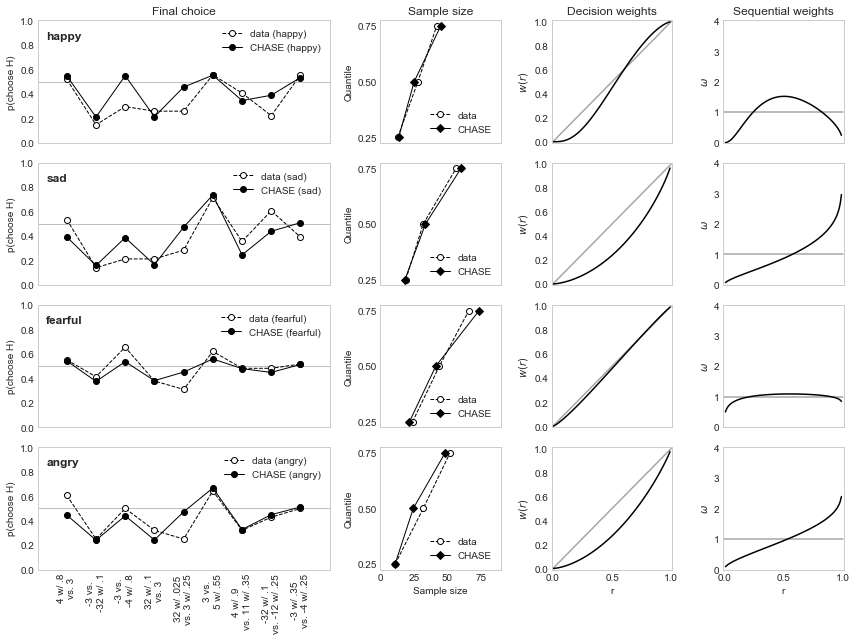

In [42]:
n_prob = len(problems)

fig = plt.subplots(nrows=4, ncols=5, figsize=(12, 9), sharex=True)

for j, group in enumerate(['happy', 'sad', 'fearful', 'angry']):


    # choice probs
    axi = plt.subplot2grid((4,5), (j,0), colspan=2)
    axi.text(0.03, .85, group, fontsize=12, fontweight='semibold', transform=axi.transAxes)
    axi.plot([0, n_prob+1], [.5, .5], '-', color='gray', alpha=.5, linewidth=1)
    axi.plot(range(1, n_prob+1), cp[group], '--o', label=('data (%s)' % group), color='black', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(range(1, n_prob+1), bf_cp[group], '-o', color=cols[0], label=('CHASE (%s)' % group), linewidth=1)
    axi.set_ylim(0, 1)
    axi.set_xlim(0, n_prob+1)
    
    if j == 3:
        axi.set_xticks(range(1,n_prob+1))
        axi.set_xticklabels([problems_str[i] for i in range(9)], rotation=90)
        #axi.set_xlabel('Problem')
    else:
        axi.set_xticks([])
    axi.set_ylabel('p(choose H)')
    axi.grid(None)
    
    if j == 0: axi.set_title('Final choice')
    axi.legend(loc='upper right')

    # sample size
    axi = plt.subplot2grid((4,5), (j,2))
    axi.plot(quant[group], [.25, .5, .75], '--o', color=cols[0], label='data', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(bf_quant[group], [.25, .5, .75], '-D', color=cols[0], label='CHASE', linewidth=1)

    if j == 0: axi.set_title('Sample size')
    axi.set_xlim(0, 90)
    if j == 3:
        axi.set_xlabel('Sample size')
    else:
        axi.set_xticks([])
    axi.set_ylabel('Quantile')
    axi.set_yticks([.25,.5,.75])
    

    axi.legend(loc='lower right')
    axi.grid(None)




    p = np.arange(0, 1, .01)

    axi = plt.subplot2grid((4,5), (j,3))
    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)

    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[0])

    if j == 0: axi.set_title('Decision weights')
    axi.set_ylabel(r'$w(r)$')
    if j==3:
        axi.set_xlabel('r')
    else:
        axi.set_xticks([])
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)


    axi = plt.subplot2grid((4,5), (j,4))
    axi.plot([0, 1], [1, 1], color='gray', alpha=.7)
    if j == 0: axi.set_title('Sequential weights')

    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prime(p, delta, gamma), '-', color=cols[0])
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,4.01)
    axi.grid(None)
    if j==3:
        axi.set_xlabel('r')
    else:
        axi.set_xticks([])
    axi.set_ylabel('$\omega$')



plt.tight_layout()
plt.show()
fig[0].savefig('%s/fitresults_frey2014_bygroup.pdf' % FIGDEST, bbox_inches='tight')

In [55]:
groups = ['happy', 'sad', 'fearful', 'angry']

colnames = ['nllh', 'k', 'N', 'bic', 'theta', 'c_sigma', 'tau_trunc', 'prelec_elevation', 'prelec_gamma']
fitdf = pd.DataFrame([best[group][colnames] for group in groups]).reset_index()
fitdf['group'] = groups
fitdf['dataset'] = 'FHR14'
fitdf['stoprule'] = 'optional'
fitdf['model'] = 0

In [56]:
fitdf

,index,nllh,k,N,bic,theta,c_sigma,tau_trunc,prelec_elevation,prelec_gamma,group,dataset,stoprule,model
0,0,1237.447543,5,243,2502.360394,128.714208,23.461028,24.368830,1.370204,1.463470,happy,FHR14,optional,0
1,0,1332.981409,5,252,2693.609963,130.316107,19.817246,26.823869,1.977634,0.878634,sad,FHR14,optional,0
2,0,1458.716753,5,261,2945.256108,146.422355,20.436597,28.848030,1.084684,1.069538,fearful,FHR14,optional,0
3,0,1322.876914,5,252,2673.400973,136.350456,22.324144,98.143473,1.827758,0.919730,angry,FHR14,optional,0


In [59]:
tab = fitdf[['dataset', 'group', 'stoprule', 'model', 'N', 'k', 'nllh', 'bic', 'theta', 'tau_trunc', 'c_sigma', 'prelec_elevation', 'prelec_gamma']]
tab.to_csv('results_fits/FHR14_bestmodel.csv')

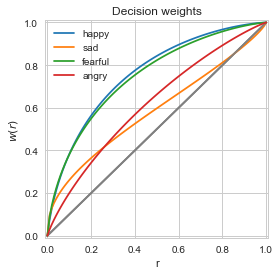

In [205]:
p = np.arange(0, 1.01, .01)

fig, axi = plt.subplots(figsize=(4,4))

for i, group in enumerate(['happy', 'sad', 'fearful', 'angry']):

    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)

    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[i], label=group)

    axi.set_title('Decision weights')
    axi.set_ylabel(r'$w(r)$')
    axi.set_xlabel('r')
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)
plt.show()

# Fit conditions individually (p_switch)

In [46]:
SWITCH_RATE = {'happy': .08,
               'fearful': .04,
               'angry': .06,
               'sad': .05}

In [47]:
OUTDIR = 'process_fitresults_FHR14_pswitch'

FIXED = {'minsamplesize': 2, 'pref_units': 'sums', 'max_T': 1000, 'N': 20000, 'switchfirst': True}

PARSETS = [#['theta', 'tau'],
           #['theta', 'tau', 'pow_gain'],
           #['theta', 'tau', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 'tau', 'pow_gain', 'prelec_gamma', 'prelec_elevation'],
           ]

m = CHASEProcessModel(problems=problems,
                      startdist='laplace')

In [48]:
#for group in ['happy', 'sad', 'fearful', 'angry']:
for group in ['fearful']:
    
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    print SIM_ID
    
    FIXED['p_switch'] = SWITCH_RATE[group]
    
    for fitting in PARSETS:

        results = fit_mlh(m, problems, grpdata, 
                          SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

process_FHR14_fearful
pow_gain	prelec_elevation	prelec_gamma	tau	theta


process_model.py:78: RuntimeWarning: invalid value encountered in divide
  w_outcomes[0] = w_outcomes[0] - phi
process_model.py:364: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  'traces': traces
process_model.py:349: RuntimeWarning: invalid value encountered in divide
  sampled_option = [sampled_option[i][:(samplesize[i]+1)] for i in range(samplesize.shape[0])]


[  5.90000000e-02   1.48800000e+00   1.69300000e+00   9.73010000e+01
   4.30870000e+01] 1901.71549984
[  0.994   1.455   2.641  46.069  10.197] 2266.38915113
[  0.295   0.144   2.696  39.813  22.073] 1571.54588224
[  1.265   2.521   2.004   7.395  16.527] 2246.8603616
[  1.143   2.446   2.497  60.369  38.625] 2036.64193842
[  1.539   0.535   2.917  27.394  16.79 ] 2252.90188555
[  1.106   2.014   1.921  95.318  23.739] 2049.26669106
[  1.855   2.786   1.329  88.11    9.899] 2272.8838951
[  0.882   0.864   2.953  29.926  34.821] 1847.00400728
[  1.041   2.432   0.071   2.566  33.086] 1690.88030303
[  1.656   0.807   1.884  33.564  35.864] 2226.40699979
[  0.575   2.313   1.137  12.231  40.145] 1861.40266741
[  0.851   2.235   0.575  25.113   2.502] 2415.69700972
[  0.509   1.736   0.175  62.824  42.24 ] 1617.89013566
[  0.669   2.329   1.253  77.598  48.047] 1877.60862315
[  1.80000000e-02   1.84100000e+00   2.00000000e-02   5.71320000e+01
   1.11810000e+01] 1624.62845695
[  8.80000000e

process_model.py:346: RuntimeWarning: invalid value encountered in divide
  outcome_ind = None


[  1.621   2.848   0.121  74.226   0.297] 2762.88932285
[  0.945   1.624   0.321  41.452  31.64 ] 1636.37854784
[  1.198   0.107   0.899  73.244  21.946] 2309.49597582
[  1.577   0.647   2.049  31.635  37.301] 2177.39507421
[  1.169   1.557   0.719  83.898   6.077] 2414.44956556
[  1.474   1.351   2.806  37.789  17.897] 2283.21194892
[  0.773   0.481   0.24   89.414   6.55 ] 2440.0207708
[  1.405   0.336   0.372  23.995  30.693] 2211.39757979
[  1.574   2.18    1.761  14.478  12.08 ] 2300.6597186
[  0.435   0.753   1.8    36.971  26.666] 1621.97162395
[  0.178   1.367   0.445  62.617  34.694] 1655.65228004
[  1.37    0.308   0.533  84.63   48.857] 1983.16218448
[  0.787   0.668   2.538  93.345  29.443] 1800.45257493
[  1.082   1.678   1.23    5.028  36.036] 1714.8785503
[  0.916   2.989   2.858  57.37   40.957] 2085.09847514
[  1.97700000e+00   4.80000000e-02   7.59000000e-01   6.49250000e+01
   3.77140000e+01] 2437.66023843
[  0.142   2.057   2.999  59.846  46.304] 2062.92381751
[  1.

KeyboardInterrupt: 

In [35]:
fitting = PARSETS[0]

best = {}
pred = {}

for group in ['happy', 'sad', 'fearful', 'angry']:
    grpdata = data[data.group==group]
    SIM_ID = 'process_FHR14_%s' % group
    FIXED['p_switch'] = SWITCH_RATE[group]

    best[group] = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred[group] = predict_from_result(m, problems, grpdata, SIM_ID, FIXED, 
                                      fitting = fitting, outdir=OUTDIR)
    print best[group]

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1241.47
k                                                                   5
N                                                                 243
bic                                                            2510.4
pow_gain                                                    0.0285693
prelec_elevation                                             0.269865
prelec_gamma                                                  1.38986
tau                                                           43.0577
theta                                                         13.6943
sim_id              process_FHR14_happy(pow_gain,prelec_elevation,...
Name: 0, dtype: obje

In [42]:
for group in ['happy', 'sad', 'fearful', 'angry']:
    cp[group] = data[data.group==group].groupby('problem').apply(lambda d: np.mean(d.choice))
    bf_cp[group] = pred[group]['cp']

    quant[group] = mquantiles(data[data.group==group].samplesize)
    bf_quant[group] = pred[group][['ss(.25)', 'ss(.5)', 'ss(.75)']].mean()

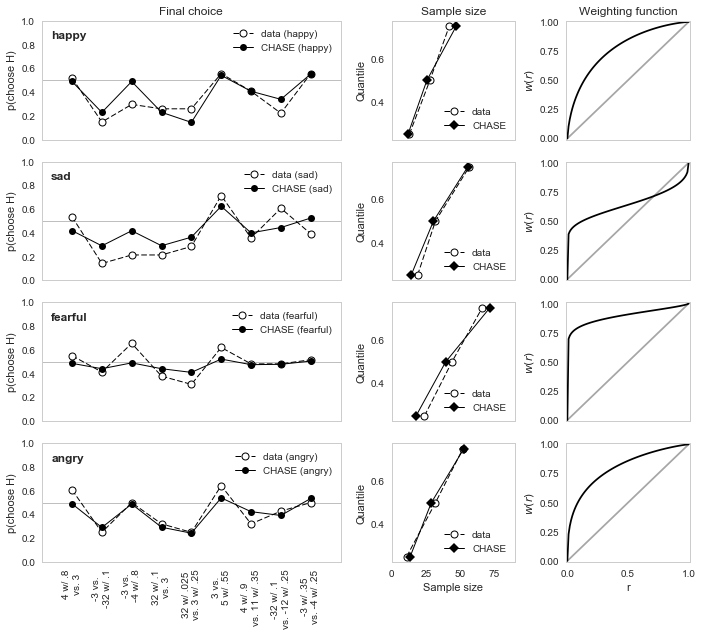

In [43]:
from mypy.viz import tableau20
cols = [tableau20[0], tableau20[2], tableau20[4], tableau20[6]]
cols = ['black', 'black', 'black', 'black']

n_prob = len(problems)

fig = plt.subplots(4, 4, figsize=(10, 9), sharex=True)

for j, group in enumerate(['happy', 'sad', 'fearful', 'angry']):


    # choice probs
    axi = plt.subplot2grid((4,4), (j,0), colspan=2)
    axi.text(0.03, .85, group, fontsize=12, fontweight='semibold', transform=axi.transAxes)
    axi.plot([0, n_prob+1], [.5, .5], '-', color='gray', alpha=.5, linewidth=1)
    axi.plot(range(1, n_prob+1), cp[group], '--o', label=('data (%s)' % group), color='black', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(range(1, n_prob+1), bf_cp[group], '-o', color=cols[0], label=('CHASE (%s)' % group), linewidth=1)
    axi.set_ylim(0, 1)
    axi.set_xlim(0, n_prob+1)
    
    if j == 3:
        axi.set_xticks(range(1,n_prob+1))
        axi.set_xticklabels([problems_str[i] for i in range(9)], rotation=90)
        #axi.set_xlabel('Problem')
    else:
        axi.set_xticks([])
    axi.set_ylabel('p(choose H)')
    axi.grid(None)
    
    if j == 0: axi.set_title('Final choice')
    axi.legend(loc='upper right')

    # sample size
    axi = plt.subplot2grid((4,4), (j,2))
    axi.plot(quant[group], [.25, .5, .75], '--o', color=cols[0], label='data', linewidth=1,
             markeredgecolor='black', markerfacecolor='white', markeredgewidth=1)
    axi.plot(bf_quant[group], [.25, .5, .75], '-D', color=cols[0], label='CHASE', linewidth=1)

    if j == 0: axi.set_title('Sample size')
    axi.set_xlim(0, 90)
    #axi.legend(loc='upper left')
    if j == 3:
        axi.set_xlabel('Sample size')
    else:
        axi.set_xticks([])
    axi.set_ylabel('Quantile')
    

    axi.legend(loc='lower right')
    axi.grid(None)




    p = np.arange(0, 1.01, .01)


    axi = plt.subplot2grid((4,4), (j,3))
    axi.plot([0, 1], [0, 1], color='gray', alpha=.7)


    delta = best[group]['prelec_elevation']
    gamma = best[group]['prelec_gamma']
    axi.plot(p, w_prelec(p, delta, gamma), '-', color=cols[0])

    if j == 0: axi.set_title('Weighting function')
    axi.set_ylabel(r'$w(r)$')
    if j==3:
        axi.set_xlabel('r')
    else:
        axi.set_xticks([])
    axi.legend()
    axi.set_xlim(-.01,1.01)
    axi.set_ylim(-.01,1.01)
    axi.grid(None)



plt.tight_layout()
plt.show()
#fig[0].savefig('%s/fitresults_frey2014_bygroup.pdf' % FIGDEST, bbox_inches='tight')

In [44]:
groups = ['happy', 'sad', 'fearful', 'angry']

colnames = ['nllh', 'k', 'N', 'bic', 'theta', 'tau', 'pow_gain', 'prelec_elevation', 'prelec_gamma']
fitdf = pd.DataFrame([best[group][colnames] for group in groups]).reset_index()
fitdf['group'] = groups

In [45]:
fitdf

,index,nllh,k,N,bic,theta,tau,pow_gain,prelec_elevation,prelec_gamma,group
0,0,1241.466137,5,243,2510.397581,13.694268,43.057746,0.028569,0.269865,1.389858,happy
1,0,1338.550289,5,252,2704.747724,15.702699,39.786267,0.012799,0.518055,0.395953,sad
2,0,1459.521819,5,261,2946.866241,28.370094,48.000452,0.044146,0.126165,0.688497,fearful
3,0,1322.364975,5,252,2672.377096,16.568555,52.557158,0.011750,0.235685,1.198122,angry
